In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# import sys, os
# from os.path import join as joinph
# path_to_fastai = '../fastai/'; 
# if path_to_fastai not in sys.path: sys.path.insert(1, path_to_fastai)

In [2]:
import torch
torch.cuda.is_available(), torch.backends.cudnn.enabled, torch.__version__

(True, True, '1.4.0')

In [3]:
import fastai
fastai.__version__

'1.0.59'

In [4]:
from fastai.tabular import *

In [5]:
import pandas as pd
import numpy as np

### tabledata

In [72]:
# running window 
bptt = 5
nb = len(df)-bptt

dat = np.empty((nb,bptt+1))
for i in range(nb): 
    dat[i,:] = df['A'].iloc[i:i+bptt+1]
dat = pd.DataFrame(dat)
'make col names str'
dat.columns = list(map(str, range(bptt+1)))
dat.head(3)

,0,1,2,3,4,5
0,-0.500000,-0.497996,-0.495992,-0.493988,-0.491984,-0.489980
1,-0.497996,-0.495992,-0.493988,-0.491984,-0.489980,-0.487976
2,-0.495992,-0.493988,-0.491984,-0.489980,-0.487976,-0.485972


In [73]:
data = TabularDataBunch.from_df('.', dat, dep_var=str(bptt), 
                                valid_idx=list(range(valid_idx[0], len(dat))), 
                                cont_names=dat.columns.tolist()[:bptt], bs=12,
                                num_workers=0)

In [78]:
data.show_batch()

0,1,2,3,4,target
0.1012,0.1032,0.1052,0.1072,0.1092,0.111222446
-0.4479,-0.4459,-0.4439,-0.4419,-0.4399,-0.43787575
-0.0070,-0.0050,-0.0030,-0.0010,0.0010,0.003006012
0.1874,0.1894,0.1914,0.1934,0.1954,0.19739479
0.1854,0.1874,0.1894,0.1914,0.1934,0.19539078


In [117]:
learn = tabular_learner(data, layers=[10])#, metrics=accuracy)

In [118]:
learn.model = m

### From Here
https://github.com/pytorch/examples/blob/master/time_sequence_prediction/generate_sine_wave.py

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# import matplotlib # matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)): #splits fill data batchxN into N*[batchx1] chunks
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [11]:
np.random.seed(2)

T = 10 # 20
L = 200 # 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
# torch.save(data, open('traindata.pt', 'wb'))

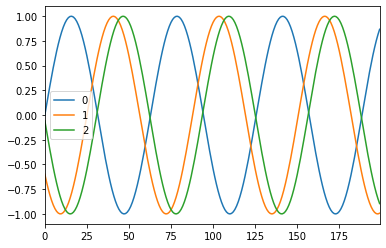

In [13]:
pd.DataFrame(data[:3].T).plot();

In [14]:
    np.random.seed(0)
    torch.manual_seed(0)
    # load data and make training set
    input = torch.from_numpy(data[3:, :-1])
    target = torch.from_numpy(data[3:, 1:])
    test_input = torch.from_numpy(data[:3, :-1])
    test_target = torch.from_numpy(data[:3, 1:])
    # build the model
    seq = Sequence()
    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

In [17]:
input.size(1)

199

STEP:  0
loss: 0.0006910542939933928
loss: 0.000655513884184248
loss: 0.0006003799349216718
loss: 0.0005351743814207559
loss: 0.0004900560694127275
loss: 0.0004538854675269308
loss: 0.00044044535760086627
loss: 0.0004318729020580131
loss: 0.00042575573593683653
loss: 0.00041820045117795283
loss: 0.0003909615262443076
loss: 0.0003055782052581766
loss: 0.00025580181073648044
loss: 0.00023454478875165773
loss: 0.00022336912160055933
loss: 0.00021971956111756065
loss: 0.00021268858141114112
loss: 0.00021074244631928755
loss: 0.0002088729004198998
loss: 0.000204034038992247
test loss: 0.00012998567316430877
STEP:  1
loss: 0.000196170330506922
loss: 0.00018728684094730785
loss: 0.00018131733895765135
loss: 0.00017475372255182692
loss: 0.00016622745359007006
loss: 0.00017275634038521186
loss: 0.0001589979979387637
loss: 0.00015705963728539002
loss: 0.0001521232178612446
loss: 0.00015228314419081951
loss: 0.00014591684374236813
loss: 0.0001432630595150121
loss: 0.00013733973762481596
loss: 0.0

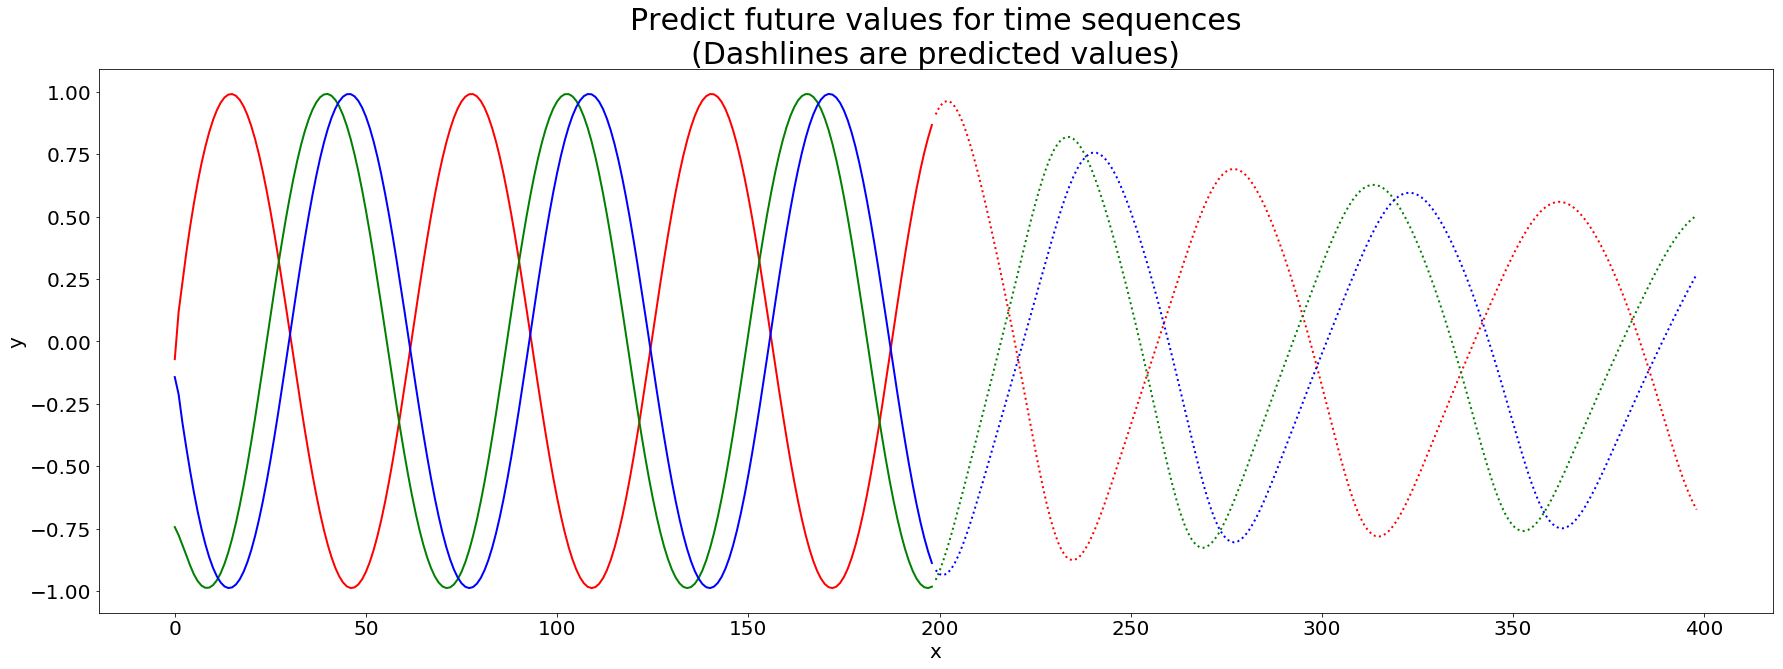

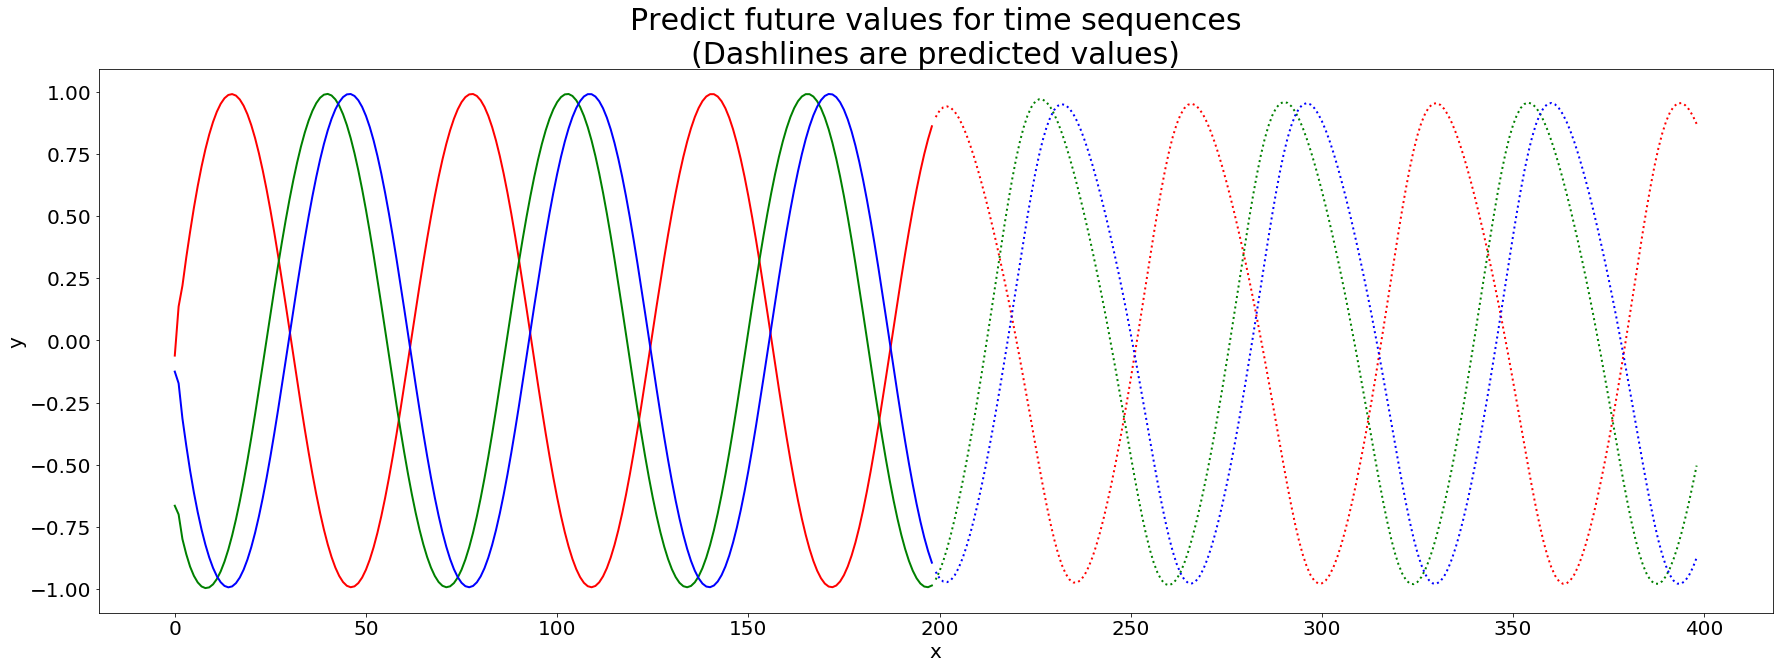

In [26]:
%%time
for i in range(4):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 200#1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')

In [42]:
o1 = seq(input)
o1.shape

torch.Size([97, 199])

In [63]:
pred = seq(test_input, future=1)
pred.shape

torch.Size([3, 200])

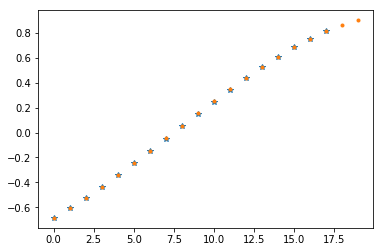

In [64]:
plt.plot(test_input.numpy()[0,181:199], '*')
plt.plot(pred.data.numpy()[0,180:200], '.')

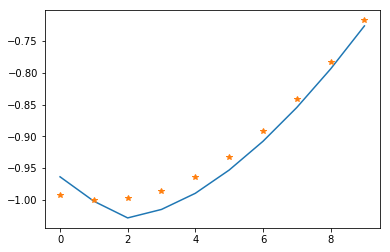

In [45]:
plt.plot(o1[0,:10].detach().numpy())
plt.plot(target[0,:10].detach().numpy(), '*')

## From 
https://nipunbatra.github.io/blog/2018/denoising.html

### RNN

In [6]:
np.random.seed(2)
# L copyes of sine wave with random start
T = 60 
L = 100 
N = 500

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
# data = np.sin(x / 1.0 / T).astype('float64')
data = np.sin(2*np.pi*x / T).astype('double')

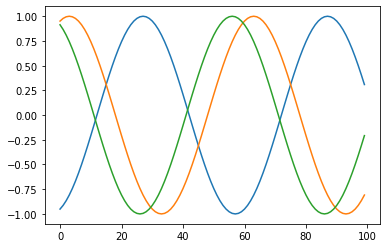

In [7]:
plt.plot(data[0,:]);
plt.plot(data[2,:]);
plt.plot(data[15,:]);

In [16]:
# train an all 3:, predict lats tpoint, test on first :3.
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

In [17]:
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, output_size=1):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size,
                          num_layers=num_layers ,batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x.view(x.shape[0],-1,1))
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

r = CustomRNN(hidden_size).double()

**L2 loss and eye inicialization**

In [19]:
r = CustomRNN(hidden_size).double()
r.rnn.weight_hh_l0.data.copy_(torch.eye(hidden_size))
optimizer = optim.Adam(r.parameters(), lr=1e-2)
#loss_func = nn.L1Loss()
loss_func = nn.MSELoss()
predictions = []
for t in range(300):
    optimizer.zero_grad()
    pred = r(input)
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, target.view(target.shape[0],-1,1))
    if t%20==0:
        print(t, loss.item())
    loss.backward()
    optimizer.step()

0 0.6462587686110408
20 0.010249598591900356
40 0.0040539180712118456
60 0.0026881717600953227
80 0.002248479535947198
100 0.002008995717074903
120 0.0018344839428157738
140 0.001690604277957455
160 0.0015626577961296807
180 0.0014445914514370569
200 0.0013339817076312938
220 0.0012303312598828766
240 0.0011342625654526919
260 0.0010461923621481568
280 0.0013454282773670975


In [25]:
target.shape

torch.Size([497, 99])

In [24]:
#pred
predictions[0].shape

(497, 99, 1)

In [20]:
with torch.no_grad():
    test_out = r(test_input)
    print(loss_func(test_out, test_target.view(test_target.shape[0],-1,1)).item())

0.0018451629732914785


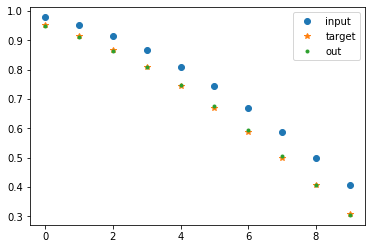

In [26]:
plt.plot(test_input[0,-10:].data.numpy(), 'o', label='input'); 
plt.plot(test_target[0,-10:].data.numpy(), '*', label='target')
plt.plot(test_out[0,-10:].data.numpy(), '.', label='out'); plt.legend();

#### predict with resetting state

In [27]:
def get_next(inp):
    with torch.no_grad():
        return torch.detach(r(inp)).squeeze()
def get_next_n(inp, n):
    res = []
    for i in range(n):
        inp = get_next(inp)
        res.append(inp[:,-1].data.numpy())
    return np.stack(res,1)

In [28]:
res = get_next_n(test_input, 100)

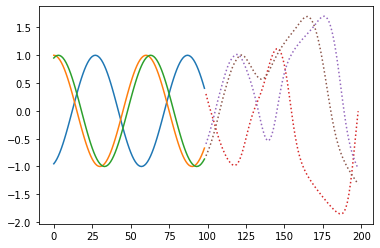

In [29]:
plt.plot(test_input.data.numpy().T)
plt.plot(range(len(test_input.T), len(test_input.T)+len(res.T)), res.T, ':')

### GRU

In [30]:
hidden_size = 30
num_layers = 1
dropout = 0
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class CustomGRU(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                           dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x.view(x.shape[0],-1,1))
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

r = CustomGRU(hidden_size).double()

**L2 loss**

In [31]:
optimizer = optim.Adam(r.parameters(), lr=1e-2)
#loss_func = nn.L1Loss()
loss_func = nn.MSELoss()
predictions = []
for t in range(300):
    optimizer.zero_grad()
    pred = r(input)
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, target.view(target.shape[0],-1,1))
    if t%20==0:
        print(t, loss.item())
    loss.backward()
    optimizer.step()

0 0.4303674536228681
20 0.010670110606448334
40 0.003010458369927359
60 0.0016001275690675774
80 0.001176930208348071
100 0.0009617817667815685
120 0.0008141262915856115
140 0.000693810982160756
160 0.0005938752821588264
180 0.0005103888728593596
200 0.00044068743153815096
220 0.0003826038146052822
240 0.0003343203981439403
260 0.000294315803695587
280 0.0002613148147807616


In [314]:
with torch.no_grad():
    test_out = r(test_input)
    print(loss_func(test_out, test_target.view(test_target.shape[0],-1,1)).item())

0.00014454652853240722


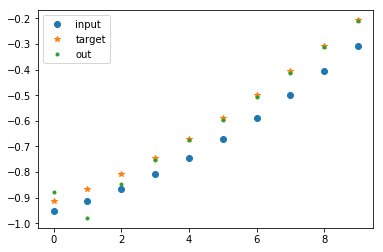

In [315]:
plt.plot(test_input[0,:10].data.numpy(), 'o', label='input'); 
plt.plot(test_target[0,:10].data.numpy(), '*', label='target')
plt.plot(test_out[0,:10].data.numpy(), '.', label='out'); plt.legend()

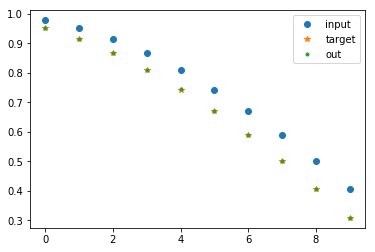

In [316]:
plt.plot(test_input[0,-10:].data.numpy(), 'o', label='input'); 
plt.plot(test_target[0,-10:].data.numpy(), '*', label='target')
plt.plot(test_out[0,-10:].data.numpy(), '.', label='out'); plt.legend()

#### predict with resetting state

In [317]:
def get_next(inp):
    with torch.no_grad():
        return torch.detach(r(inp)).squeeze()
def get_next_n(inp, n):
    res = []
    for i in range(n):
        inp = get_next(inp)
        res.append(inp[:,-1].data.numpy())
    return np.stack(res,1)

In [318]:
res = get_next_n(test_input, 100)

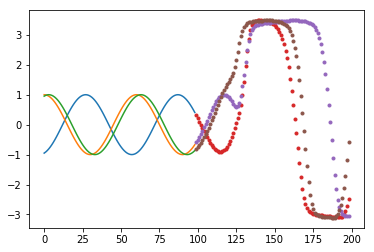

In [319]:
plt.plot(test_input.data.numpy().T)
plt.plot(range(len(test_input.T), len(test_input.T)+len(res.T)), res.T, '.')

### LSTM

In [297]:
hidden_size = 30
num_layers = 1
dropout = 0
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class CustomLSTM(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                           dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x.view(x.shape[0],-1,1))
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

r = CustomLSTM(hidden_size).double()

**L2 loss**

In [302]:
optimizer = optim.Adam(r.parameters(), lr=1e-2)
#loss_func = nn.L1Loss()
loss_func = nn.MSELoss()
predictions = []
for t in range(300):
    optimizer.zero_grad()
    pred = r(input)
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, target.view(target.shape[0],-1,1))
    if t%20==0:
        print(t, loss.item())
    loss.backward()
    optimizer.step()

0 0.46924867677204096
20 0.008369494309134896
40 0.0038501697410707504
60 0.002300566926097759
80 0.0017786464344204157
100 0.0015033455148339245
120 0.001317061289963046
140 0.0011616277229255785
160 0.001025230873765252
180 0.0009047611918759942
200 0.0007986055658433881
220 0.0007052643690558398
240 0.000623159197781666
260 0.0005508071362627624
280 0.0004869827375189967


In [304]:
with torch.no_grad():
    test_out = r(test_input)
    print(loss_func(test_out, test_target.view(test_target.shape[0],-1,1)).item())

0.000457374006907986


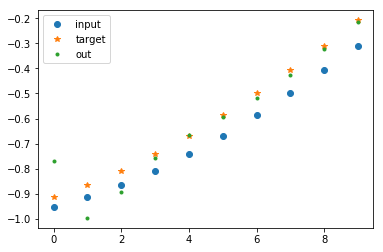

In [309]:
plt.plot(test_input[0,:10].data.numpy(), 'o', label='input'); 
plt.plot(test_target[0,:10].data.numpy(), '*', label='target')
plt.plot(test_out[0,:10].data.numpy(), '.', label='out'); plt.legend()

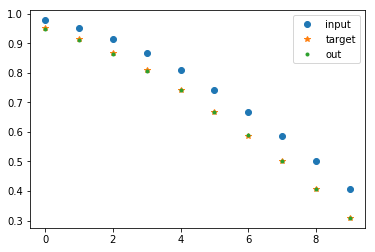

In [305]:
plt.plot(test_input[0,-10:].data.numpy(), 'o', label='input'); 
plt.plot(test_target[0,-10:].data.numpy(), '*', label='target')
plt.plot(test_out[0,-10:].data.numpy(), '.', label='out'); plt.legend()

#### predict with resetting state

In [306]:
def get_next(inp):
    with torch.no_grad():
        return torch.detach(r(inp)).squeeze()
def get_next_n(inp, n):
    res = []
    for i in range(n):
        inp = get_next(inp)
        res.append(inp[:,-1].data.numpy())
    return np.stack(res,1)

In [307]:
res = get_next_n(test_input, 100)

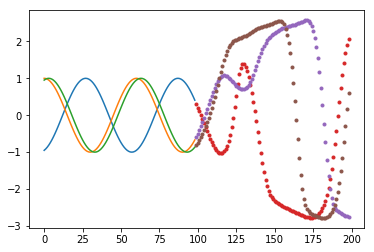

In [310]:
plt.plot(test_input.data.numpy().T)
plt.plot(range(len(test_input.T), len(test_input.T)+len(res.T)), res.T, '.')

## my data Loader and data Bunch

continues data

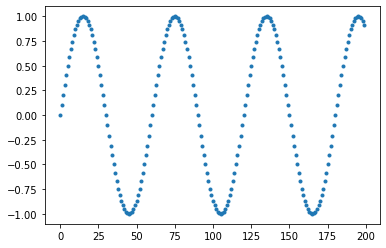

In [22]:
T = 60 
L = 20000 

x = np.arange(L)
data = np.sin(2*np.pi*x / T).astype('double')
plt.plot(data[:200],'.')

In [23]:
# data classes
class LM_PreLoader(Dataset):
    def __init__(self, data, bs=64, bptt=70, shuffle=False, shift=1):
        super().__init__()
        self.data,self.bs,self.bptt,self.shuffle,self.shift = data,bs,bptt,shuffle,shift
        self.data1D = (len(data.shape)==1)
        total_len = len(data) if self.data1D else sum(len(t) for t in data) # generator in functions does not need extra ()
        self.n_batch = total_len // bs
        self.batchify()
    #TODO check if -1 is correct for all shifts
    def __len__(self): return ((self.n_batch-1) // self.bptt) * self.bs
    
    def __getitem__(self, idx):
        source = self.batched_data[idx % self.bs]
        seq_idx = (idx // self.bs) * self.bptt
        return source[seq_idx:seq_idx+self.bptt],source[seq_idx+self.shift:seq_idx+self.bptt+self.shift]
    
    def batchify(self):
        dat = self.data
        if self.shuffle and (not self.data1D): dat = dat[torch.randperm(len(dat))]
        stream = tensor(dat) if self.data1D else torch.cat([tensor(t) for t in dat])
        self.batched_data = stream[:self.n_batch * self.bs].view(self.bs, self.n_batch)
        
def round_multiple(x, mult, round_down=False):
    "Round `x` to nearest multiple of `mult`"
    def _f(x_): return (int if round_down else round)(x_/mult)*mult
    res = L(x).map(_f)
    return res if is_listy(x) else res[0]
def is_listy(x):
    "`isinstance(x, (tuple,list,L))`"
    return isinstance(x, (tuple,list,L,slice,Generator))

# class LMDataLoader(TfmdDL):
#     def __init__(self, dataset, lens=None, cache=2, bs=64, seq_len=72, num_workers=0, **kwargs):
#         super().__init__(dataset=dataset, bs=bs, num_workers=num_workers, **kwargs)
#         self.items = ReindexCollection([(o[0] if isinstance(o, tuple) else o)
#                                           for o in dataset], cache=cache)
#         self.seq_len = seq_len
#         if lens is None: lens = [len(o) for o in self.items]
#         self.lens = ReindexCollection(lens, idxs=self.items.idxs)
#         # The "-1" is to allow for final label
#         self.m = round_multiple(sum(lens)-1, bs*seq_len, round_down=True)
#         self.n = self.m//(seq_len)
#         self.spb = self.n//bs
#         self.make_chunks()

#     def make_chunks(self): self.chunks = Chunks(self.items, self.lens)
#     def shuffle_fn(self,idxs):
#         self.items.shuffle()
#         self.make_chunks()
#         return idxs

#     def create_item(self, seq):
#         if seq>=self.n: raise IndexError
#         st = ((seq%self.bs)*self.spb + (seq//self.bs)) * self.seq_len
#         txt = self.chunks[st : st+self.seq_len+1]
#         return LMTensorText(txt[:-1]),txt[1:]

In [24]:
val_pct = 0.2
val_idx = int(len(data)*(1-val_pct))
trn = data[:val_idx]
val = data[val_idx:]

In [37]:
temp_ds = LM_PreLoader(np.arange(50), bs=3, shuffle=True, bptt=5)

C:\Users\andrey.bogdan\AppData\Local\Continuum\anaconda3\envs\fastai175\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


In [48]:
len(temp_ds), temp_ds[2][0], temp_ds[5][0]

(9, tensor([32, 33, 34, 35, 36]), tensor([37, 38, 39, 40, 41]))

In [25]:
trn_ds = LM_PreLoader(trn, bs=18, shuffle=True, bptt=200)
val_ds = LM_PreLoader(val, bs=18, shuffle=True, bptt=200)

In [35]:
len(val_ds)

18

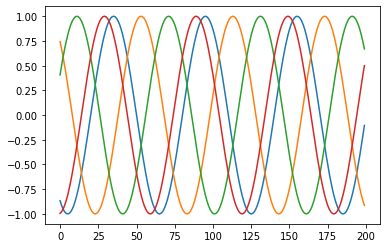

In [29]:
plt.plot(val_ds[0][0].data.numpy())
plt.plot(val_ds[1][0].data.numpy())
plt.plot(val_ds[2][0].data.numpy())
plt.plot(val_ds[3][0].data.numpy())

In [49]:
trn_dl = DataLoader(trn_ds, batch_size=18, shuffle=False, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=18, shuffle=False, num_workers=0)
db = DataBunch(trn_dl, val_dl)

In [11]:
# tmpdata = np.arange(50)*1.0
# tmpds = LM_PreLoader(tmpdata, bs=2, bptt=10)
# tmpds.loss_func = nn.MSELoss()
# tmpdl =  DataLoader(tmpds, batch_size=2, shuffle=False, num_workers=0)
# db = DataBunch(tmpdl,tmpdl)

In [50]:
x, y = next(iter(db.train_dl))

RuntimeError: CUDA error: unknown error

In [51]:
x.shape, y.shape

NameError: name 'y' is not defined

loss_func1 = FlattenedLoss(nn.MSELoss)
loss_func1(r(x), y)
C:\Users\andrey.bogdan\AppData\Local\Continuum\anaconda3\envs\fastai10\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([3600])) that is different to the input size (torch.Size([3600, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
tensor(0.5084, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>)

In [23]:
def my_mse(inp, targ): return F.mse_loss(inp, targ.view(targ.shape[0],-1,1))

### resetting model

In [111]:
#MODEL
hidden_size = 30
num_layers = 1
dropout = 0
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class ResetGRU(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                           dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x.view(x.shape[0],-1,1))
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

r = ResetGRU(hidden_size).double().cuda()

todo: make transformer layer to transform tensor dimentions to acceptable one (batch, sec, dim)

In [112]:
learn = Learner(db, r, loss_func=my_mse)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


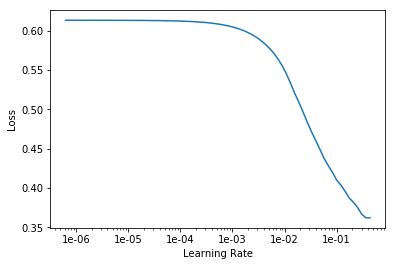

In [113]:
learn.lr_find()
learn.recorder.plot()

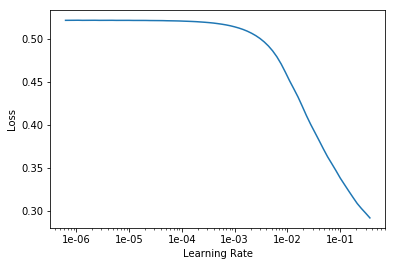

In [26]:
learn.recorder.plot()

In [114]:
learn.fit(100, 3e-2)

epoch,train_loss,valid_loss,time
0,0.330115,0.125550,00:00
1,0.187635,0.033996,00:00
2,0.126001,0.024407,00:00
3,0.093682,0.009684,00:00
4,0.073755,0.001213,00:00
5,0.059723,0.003872,00:00
6,0.049425,0.003971,00:00
7,0.041791,0.001043,00:00
8,0.035795,0.001036,00:00
9,0.030933,0.001534,00:00


#### evaluate

In [115]:
with torch.no_grad():
    it = iter(db.valid_dl)
    for x, y in it:
        rx = r(x)
        print(my_mse(rx, y))

tensor(6.2975e-05, device='cuda:0', dtype=torch.float64)


In [116]:
x.shape, y.shape, rx.shape

(torch.Size([18, 200]), torch.Size([18, 200]), torch.Size([18, 200, 1]))

In [117]:
def get_np(t): return t.cpu().data.numpy()

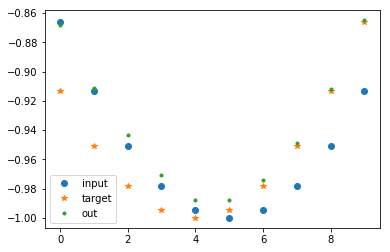

In [118]:
plt.plot(get_np(x[0,:10]), 'o', label='input'); 
plt.plot(get_np(y[0,:10]), '*', label='target')
plt.plot(get_np(rx[0,:10])[:,0], '.', label='out'); plt.legend()

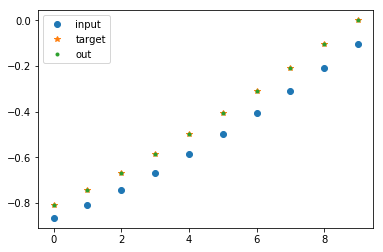

In [119]:
plt.plot(get_np(x[0,-10:]), 'o', label='input'); 
plt.plot(get_np(y[0,-10:]), '*', label='target')
plt.plot(get_np(rx[0,-10:])[:,0], '.', label='out'); plt.legend()

#### predict with resetting state

In [120]:
def get_next(inp):
        return torch.detach(r(inp)).squeeze()
def get_next_n(inp, n):
    with torch.no_grad():
        res = []
        for i in range(n):
            inp = get_next(inp)
            res.append(get_np(inp[:,-1]))
    return np.stack(res,1)

In [121]:
res = get_next_n(x, 100)

In [122]:
res.shape

(18, 100)

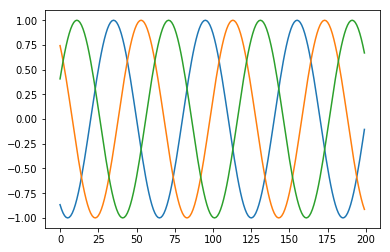

In [123]:
inp = get_np(x[:3,:]).T
plt.plot(inp);

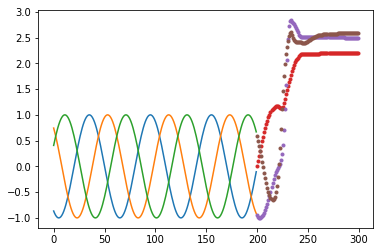

In [124]:
inp = get_np(x[:3,:]).T
plt.plot(inp);
plt.plot(range(len(inp), len(inp)+len(res.T)), res[:3,:].T, '.')

### Statefull model

In [135]:
#MODEL
hidden_size = 30
num_layers = 1
dropout = 0
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class StatefullGRU(nn.Module):
    def __init__(self, hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.bs, self.hidden_size, self.num_layers = 0, hidden_size, num_layers
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                           dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)

#         self.act = nn.Tanh()
    def forward(self, x):
        # h  Defaults to zero if not provided
        bs = x.size(0)
        if bs!=self.bs:
            self.bs = bs
            self.reset()
        pred, hidden = self.rnn(x.view(bs,-1,1), self.hidden)
        self.hidden = self.hidden.detach()
        pred = self.linear(pred)
        return pred
    
    def reset(self): 
        #next.new makes sure same dtype and device
        print('reset hidden, bs=', self.bs)
        self.hidden = next(self.parameters()).new_zeros(self.num_layers, self.bs, self.hidden_size)

r = StatefullGRU(hidden_size).double().cuda()


todo: make transformer layer to transform tensor dimentions to acceptable one (batch, sec, dim)

In [136]:
learn = Learner(db, r, loss_func=my_mse)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


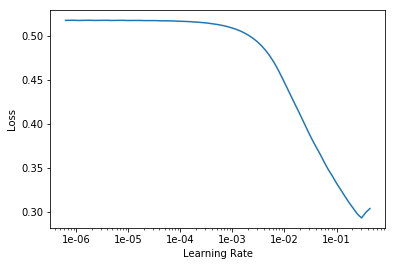

In [99]:
learn.lr_find()
learn.recorder.plot()

In [138]:
learn.fit(20, 3e-2)

epoch,train_loss,valid_loss,time
0,0.027162,0.007801,00:00
1,0.019331,0.007005,00:00
2,0.014717,0.009509,00:00
3,0.011944,0.005985,00:00
4,0.010171,0.001920,00:00
5,0.008743,0.001665,00:00
6,0.007490,0.002057,00:00
7,0.006478,0.001417,00:00
8,0.005672,0.000627,00:00
9,0.004992,0.000387,00:00


#### evaluate

In [139]:
with torch.no_grad():
    it = iter(db.valid_dl)
    for x, y in it:
        rx = r(x)
        print(my_mse(rx, y))

tensor(0.0002, device='cuda:0', dtype=torch.float64)


In [140]:
x.shape, y.shape, rx.shape

(torch.Size([18, 200]), torch.Size([18, 200]), torch.Size([18, 200, 1]))

In [207]:
rx.squeeze()

tensor([[ 0.6285,  0.5994,  0.6121,  ...,  0.5740,  0.5707,  0.5724],
        [ 0.6674,  0.6495,  0.6617,  ...,  1.4007,  1.3795,  1.4198],
        [ 1.3164,  1.2244,  1.2181,  ...,  0.9725,  0.9652,  0.9484],
        ...,
        [-0.7860, -0.8498, -0.8794,  ..., -1.1660, -1.1682, -1.1649],
        [-1.1997, -1.2048, -1.1256,  ..., -1.1653, -1.1263, -1.1202],
        [-0.6489, -0.6486, -0.6124,  ..., -0.5906, -0.5898, -0.6004]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SqueezeBackward0>)

In [208]:
def get_np(t): return t.squeeze().cpu().data.numpy()

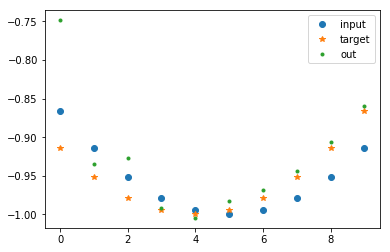

In [142]:
plt.plot(get_np(x[0,:10]), 'o', label='input'); 
plt.plot(get_np(y[0,:10]), '*', label='target')
plt.plot(get_np(rx[0,:10])[:,0], '.', label='out'); plt.legend()

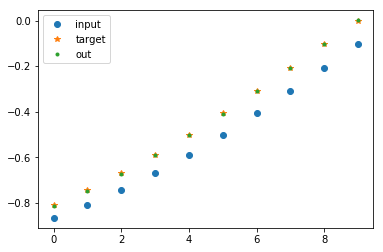

In [143]:
plt.plot(get_np(x[0,-10:]), 'o', label='input'); 
plt.plot(get_np(y[0,-10:]), '*', label='target')
plt.plot(get_np(rx[0,-10:])[:,0], '.', label='out'); plt.legend()

#### predict with resetting state

In [144]:
def get_next(inp):
        return torch.detach(r(inp)).squeeze()
def get_next_n(inp, n):
    with torch.no_grad():
        res = []
        for i in range(n):
            inp = get_next(inp)
            res.append(get_np(inp[:,-1]))
    return np.stack(res,1)

In [145]:
res = get_next_n(x, 100)

In [146]:
res.shape

(18, 100)

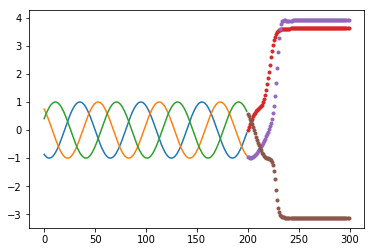

In [147]:
inp = get_np(x[:3,:]).T
plt.plot(inp);
plt.plot(range(len(inp), len(inp)+len(res.T)), res[:3,:].T, '.')

## from https://www.tensorflow.org/tutorials/structured_data/time_series

In [8]:
folder = r'C:\Users\andrey.bogdan\Downloads\Data'
name = 'jena_climate_2009_2016.csv.zip'
df = pd.read_csv(os.path.join(folder, name))
df.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

In [9]:
TRAIN_SPLIT = 300000
uni_data = df['T (degC)']

In [10]:
# val_pct = 0.2
# val_idx = int(len(data)*(1-val_pct))
trn = uni_data.values[:TRAIN_SPLIT]
val = uni_data.values[TRAIN_SPLIT:]

In [11]:
#normalize
uni_train_mean = trn.mean()
uni_train_std = trn.std()

trn = (trn-uni_train_mean)/uni_train_std
val = (val-uni_train_mean)/uni_train_std

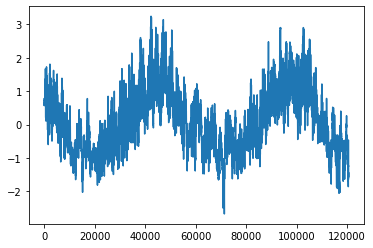

In [12]:
plt.plot(val)

In [13]:
bs = 256
bptt = 20

In [14]:
trn_ds = LM_PreLoader(trn, bs=bs, shuffle=True, bptt=bptt)
val_ds = LM_PreLoader(val, bs=bs, shuffle=True, bptt=bptt)

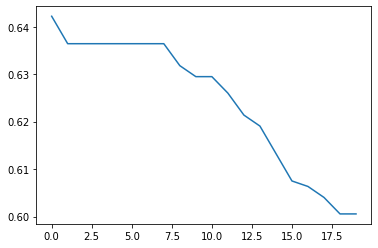

In [15]:
plt.plot(val[:20])

In [16]:
trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=False, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=0)
db = DataBunch(trn_dl, val_dl)

In [17]:
#model LSTM:
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class ResetLSTM(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                           dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x.view(x.shape[0],-1,1))
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

In [18]:
hidden_size = 8
num_layers = 1
dropout = 0
r = ResetLSTM(hidden_size).double()

In [19]:
def my_mse(inp, targ): return F.mse_loss(inp, targ.view(targ.shape[0],-1,1))

In [20]:
trn_ds[0]

(tensor([-1.9977, -2.0428, -2.0544, -2.0312, -2.0266, -2.0011, -1.9513, -1.9513,
         -1.9849, -2.0451, -2.0833, -2.0972, -2.0938, -2.0914, -2.0718, -2.0718,
         -2.0764, -2.0891, -2.0926, -2.1042], dtype=torch.float64),
 tensor([-2.0428, -2.0544, -2.0312, -2.0266, -2.0011, -1.9513, -1.9513, -1.9849,
         -2.0451, -2.0833, -2.0972, -2.0938, -2.0914, -2.0718, -2.0718, -2.0764,
         -2.0891, -2.0926, -2.1042, -2.1042], dtype=torch.float64))

In [21]:
learn = Learner(db, r, loss_func=my_mse)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


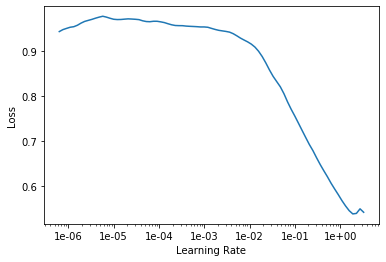

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
r

ResetLSTM(
  (rnn): LSTM(1, 8, batch_first=True)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [24]:
learn.fit(10, 1e-1)

epoch,train_loss,valid_loss,time
0,0.039656,0.002202,00:00
1,0.010555,0.001214,00:00
2,0.003876,0.001010,00:00
3,0.001872,0.000891,00:00
4,0.001278,0.001199,00:00
5,0.001158,0.000766,00:00
6,0.001013,0.000768,00:00
7,0.000968,0.000939,00:00
8,0.001051,0.001091,00:00
9,0.001123,0.000779,00:00


In [25]:
def get_np(t): return t.squeeze().cpu().data.numpy()

In [26]:
def get_n_takes(n):
    xs, ys, rxs = [], [], []
    for i, (x,y) in enumerate(db.valid_dl):
        if i>n-1: break
        rx = r(x)
        xs.append(x)
        ys.append(y)
        rxs.append(rx)
    return xs, ys, rxs

In [27]:
def plot_takes(xs, ys, rxs):
    for x, y, rx in zip(xs, ys, rxs):
#     plt.plot(get_np(x[0]), 'o', label='input'); 
        plt.plot(get_np(y[0]), '-o', label='target')
        plt.plot(get_np(rx[0]), '-*', label='out'); plt.legend()
        plt.show()

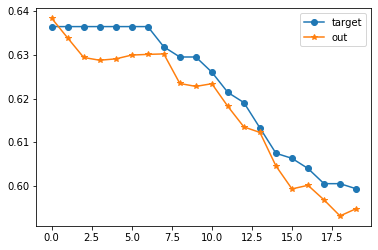

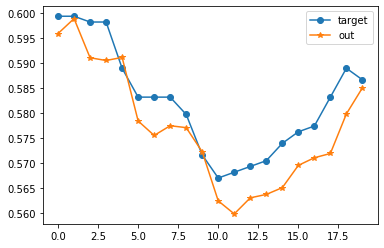

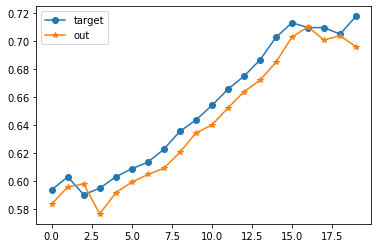

In [28]:
plot_takes(*get_n_takes(3))

### Multivariate

In [32]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head(3)

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018E1FA76D48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000018E33657508>], dtype=object)

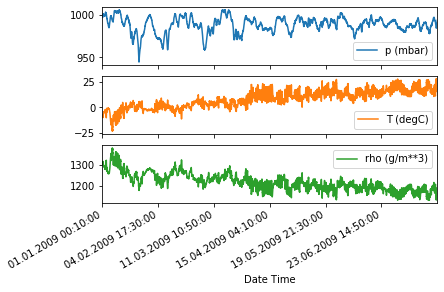

In [36]:
features[:30000].plot(subplots=True)

In [37]:
TRAIN_SPLIT = 300000

In [ ]:
dataset[:,1]

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

#### LM_PreLoader

In [343]:
# data classes
def my_listify(p):
    return p if isinstance(p, list) else [p]
class LM_PreLoader(Dataset):
    def __init__(self, data, target_col=0, bs=64, bptt=70, shuffle=True, 
                 shift=1, input_step=1, output_step=1):
        '''
        - input data:
            np/torch[timesteps, channels] 
            or list of files
            [ np/torch[timesteps, channels] ] 
       
        - output shape:
            ([timesteps, channels], [timesteps, 1])
        '''
        super().__init__()
        self.bs,self.bptt,self.shuffle,self.shift,self.input_step,self.output_step = bs,bptt,shuffle,shift,input_step,output_step
        self.target_col = my_listify(target_col)
        self.data = my_listify(data)
        total_len = sum(len(t) for t in self.data) # generator in functions does not need extra ()
        self.n_batch = total_len // bs
        self.batchify()
    #TODO check if -1 is correct for all shifts
    def __len__(self): return ((self.n_batch-self.shift) // self.bptt) * self.bs
    
    def __getitem__(self, idx):
        source = self.batched_data[idx % self.bs]
        seq_idx = (idx // self.bs) * self.bptt
        return (source[seq_idx:seq_idx+self.bptt][::self.input_step], 
                source[seq_idx+self.shift:seq_idx+self.bptt+self.shift, self.target_col][::self.output_step])
    
    def batchify(self):
        dat = self.data
        #shuffle files in list
        idx = torch.randperm(len(dat)) if self.shuffle else range(len(dat))
        stream = torch.cat([tensor(dat[i]) for i in idx])
        self.batched_data = stream[:self.n_batch * self.bs].view(self.bs, self.n_batch, -1)

In [485]:
params = dict(bs = 50,
            bptt = 720,
            shift = 72,
            input_step = 6,
            output_step = 6,
            target_col = 1)
trn_ds = LM_PreLoader(dataset[:TRAIN_SPLIT], **params)
val_ds = LM_PreLoader(dataset[TRAIN_SPLIT:], **params)
len(trn_ds), len(val_ds)

(400, 150)

In [486]:
trn_ds[0][0].shape, trn_ds[0][1].shape

(torch.Size([120, 3]), torch.Size([120, 1]))

([<matplotlib.lines.Line2D at 0x18ea7c8b5c8>,
 [<matplotlib.lines.Line2D at 0x18ea7cd6188>])

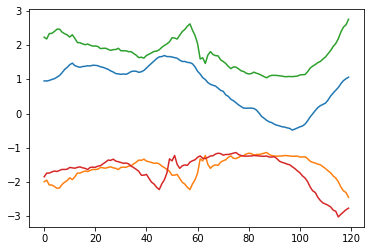

In [487]:
plt.plot(get_np(trn_ds[0][0])), plt.plot(get_np(trn_ds[0][1]))

In [488]:
trn_dl = DataLoader(trn_ds, batch_size=params['bs'], shuffle=False, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=params['bs'], shuffle=False, num_workers=0)
db = DataBunch(trn_dl, val_dl)
len(trn_dl), len(val_dl)

(8, 3)

In [417]:
#model LSTM:
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class ResetLSTM(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                          dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x)
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

In [489]:
hidden_size = 32
input_size = 3
num_layers = 1
dropout = 0

r = ResetLSTM(hidden_size=hidden_size,input_size=input_size).double()

In [490]:
dli = iter(db.train_dl)
x, y = next(dli)
x.shape, y.shape

(torch.Size([50, 120, 3]), torch.Size([50, 120, 1]))

In [491]:
learn = Learner(db, r, loss_func=F.l1_loss)
rx = learn.model(x)
rx.shape, F.mse_loss(rx, y), F.l1_loss(rx,y)

(torch.Size([50, 120, 1]),
 tensor(1.0806, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>),
 tensor(0.8391, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


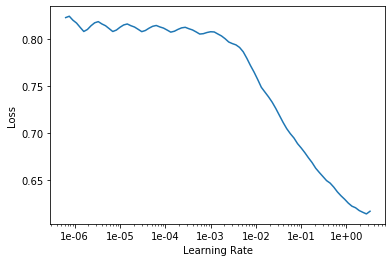

In [492]:
learn.lr_find()
learn.recorder.plot()

In [493]:
learn.fit_one_cycle(50, 1e-1)

epoch,train_loss,valid_loss,time
0,0.726072,0.537681,00:00
1,0.607968,0.436013,00:00
2,0.554225,0.440234,00:00
3,0.521524,0.440613,00:00
4,0.499951,0.434732,00:00
5,0.483100,0.416963,00:00
6,0.469616,0.412047,00:00
7,0.457415,0.398472,00:00
8,0.441271,0.349534,00:00
9,0.426162,0.380473,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


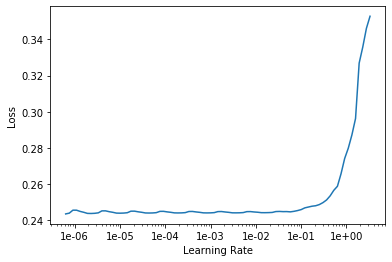

In [494]:
learn.lr_find()
learn.recorder.plot()

In [495]:
learn.fit_one_cycle(60, 2e-2)

epoch,train_loss,valid_loss,time
0,0.244341,0.265598,00:00
1,0.244302,0.265608,00:00
2,0.244271,0.265409,00:00
3,0.244222,0.265438,00:00
4,0.244168,0.265472,00:00
5,0.244116,0.265579,00:00
6,0.244093,0.265625,00:00
7,0.244128,0.265695,00:00
8,0.244132,0.265854,00:00
9,0.244195,0.265070,00:00


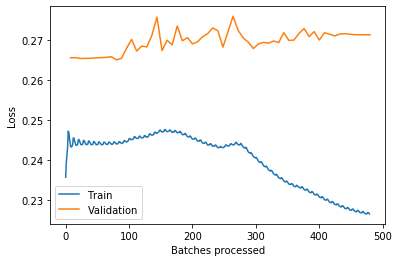

In [496]:
learn.recorder.plot_losses()

In [497]:
def get_n_takes(n):
    xs, ys, rxs = [], [], []
    for i, (x,y) in enumerate(db.valid_dl):
        print(i)
        if i==n: break
        rx = r(x)
        xs.append(x)
        ys.append(y)
        rxs.append(rx)
    return xs, ys, rxs
def plot_takes(xs, ys, rxs, bsn=0):
    for x, y, rx in zip(xs, ys, rxs):
#     plt.plot(get_np(x[0]), 'o', label='input'); 
        plt.plot(y[bsn,:], '-o', label='target')
        plt.plot(rx[bsn,:], '-*', label='out'); plt.legend()
        plt.show()

0
1
2


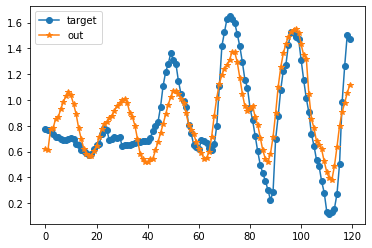

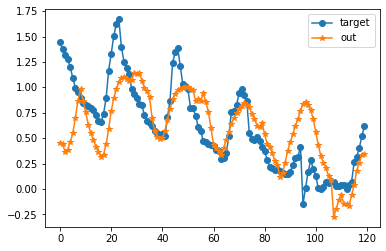

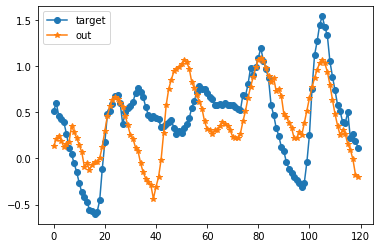

In [498]:
plot_takes(*get_n_takes(3))

0
1
2


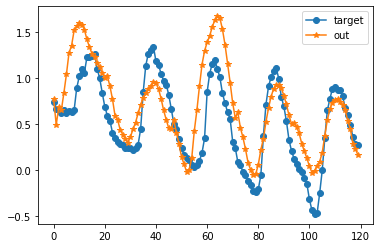

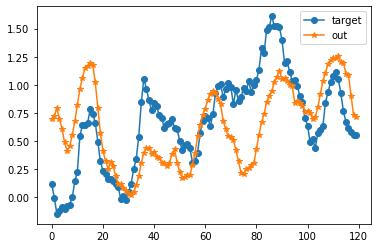

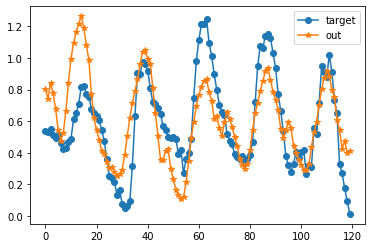

In [499]:
plot_takes(*get_n_takes(3), 1)

In [500]:
dbi = iter(db.valid_dl)
x,y = next(dbi)
rx = learn.model(x)


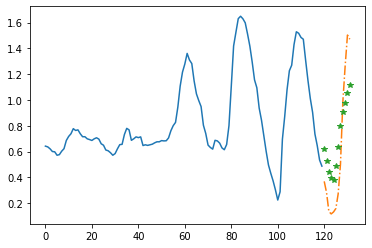

In [521]:
ch = 0
plt.plot(x[ch,:,1])
plt.plot(len(y[0])+np.arange(12),y[ch,-12:], '-.')
plt.plot(len(y[0])+np.arange(12),rx[ch,-12:], '*')

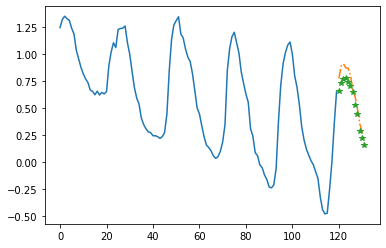

In [520]:
ch = 1
plt.plot(x[ch,:,1])
plt.plot(len(y[0])+np.arange(12),y[ch,-12:], '-.')
plt.plot(len(y[0])+np.arange(12),rx[ch,-12:], '*')

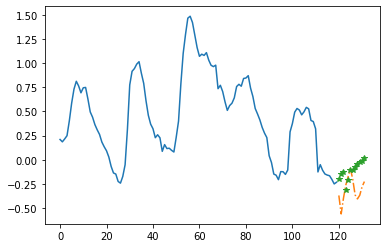

In [522]:
ch = 2
plt.plot(x[ch,:,1])
plt.plot(len(y[0])+np.arange(12),y[ch,-12:], '-.')
plt.plot(len(y[0])+np.arange(12),rx[ch,-12:], '*')

In [514]:
rx.shape

torch.Size([50, 120, 1])

In [523]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

#### Successive data

In [537]:
# data classes
def my_listify(p):
    return p if isinstance(p, list) else [p]
class Su_PreLoader(Dataset):
    def __init__(self, data, target_col=0, bptt=70, shuffle=True, 
                 shift=1, input_step=1, output_step=1):
        '''
        - input data:
            np/torch[timesteps, channels] 
            or list of files
            [ np/torch[timesteps, channels] ] 
       
        - output shape:
            ([timesteps, channels], [timesteps, 1])
        '''
        super().__init__()
        self.bptt,self.shuffle,self.shift,self.input_step,self.output_step = bptt,shuffle,shift,input_step,output_step
        self.target_col = my_listify(target_col)
        self.data = my_listify(data)
        self.total_len = sum(len(t) for t in self.data) # generator in functions does not need extra ()
        self.batchify()
    #TODO check if -1 is correct for all shifts
    def __len__(self): return self.total_len - self.bptt - self.shift
    
    def __getitem__(self, idx):
        source = self.stream
        return (source[idx:idx+self.bptt][::self.input_step], 
                source[idx+self.shift:idx+self.bptt+self.shift, self.target_col][::self.output_step])
    
    def batchify(self):
        dat = self.data
        #shuffle files in list
        idx = torch.randperm(len(dat)) if self.shuffle else range(len(dat))
        self.stream = torch.cat([tensor(dat[i]) for i in idx])


In [529]:
seq_idx

2

In [531]:
tmp = np.arange(20)[:,None]

In [538]:
rs = Su_PreLoader(tmp, bptt=4, shift=2)
rs[0]

(tensor([[0],
         [1],
         [2],
         [3]]), tensor([[2],
         [3],
         [4],
         [5]]))

In [539]:
len(rs)

14

In [540]:
params = dict(bptt = 720,
            shift = 72,
            input_step = 6,
            output_step = 6,
            target_col = 1)
trn_ds = Su_PreLoader(dataset[:TRAIN_SPLIT], **params)
val_ds = Su_PreLoader(dataset[TRAIN_SPLIT:], **params)
len(trn_ds), len(val_ds)

(299208, 119759)

In [541]:
trn_ds[0][0].shape, trn_ds[0][1].shape

(torch.Size([120, 3]), torch.Size([120, 1]))

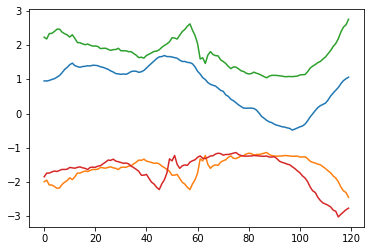

In [544]:
plt.plot(trn_ds[0][0]), plt.plot(trn_ds[0][1]);

In [556]:
bs = 500
trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=0)
db = DataBunch(trn_dl, val_dl)
len(trn_dl), len(val_dl)

(599, 240)

In [557]:
#model LSTM:
'''UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers)'''

class ResetLSTM(nn.Module):
    def __init__(self,hidden_size, input_size=1, num_layers=1, 
                 output_size=1, dropout=0):
        super().__init__()
#         self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, 
                          dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
#         self.act = nn.Tanh()
    def forward(self, x):
#         hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
#         pred, hidden = self.rnn(x, hidden)
        # h  Defaults to zero if not provided
        pred, hidden = self.rnn(x)
        # hidden shape: torch.Size([1, bs, hidden_size])) = torch.Size([1, 497, 5]))
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        pred = self.linear(pred)
        return pred

In [558]:
hidden_size = 32
input_size = 3
num_layers = 1
dropout = 0

r = ResetLSTM(hidden_size=hidden_size,input_size=input_size).double()

In [559]:
dli = iter(db.train_dl)
x, y = next(dli)
x.shape, y.shape

(torch.Size([500, 120, 3]), torch.Size([500, 120, 1]))

In [560]:
learn = Learner(db, r, loss_func=F.l1_loss)
rx = learn.model(x)
rx.shape, F.mse_loss(rx, y), F.l1_loss(rx,y)

(torch.Size([500, 120, 1]),
 tensor(1.0447, device='cuda:0', dtype=torch.float64, grad_fn=<MseLossBackward>),
 tensor(0.8278, device='cuda:0', dtype=torch.float64, grad_fn=<L1LossBackward>))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


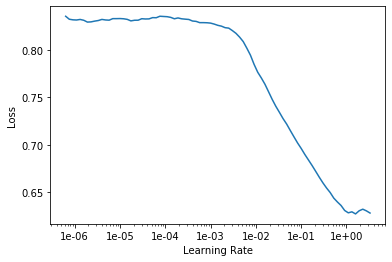

In [561]:
learn.lr_find()
learn.recorder.plot()

In [562]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,time
0,0.228528,0.260490,01:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


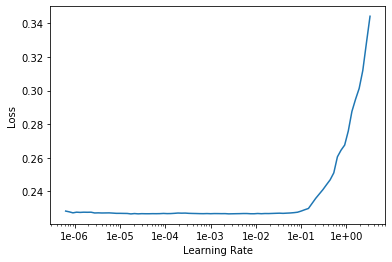

In [563]:
learn.lr_find()
learn.recorder.plot()

In [564]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.215348,0.264326,01:13


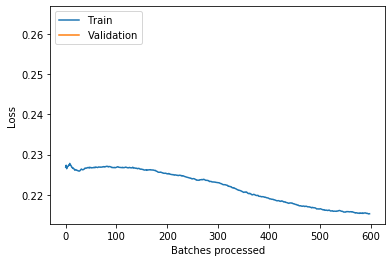

In [565]:
learn.recorder.plot_losses()

In [573]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.208531,0.267646,01:14


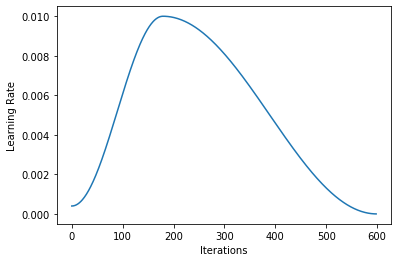

In [574]:
learn.recorder.plot_lr()

### evaluation

In [577]:
r.eval()

ResetLSTM(
  (rnn): LSTM(3, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [566]:
def get_n_takes(n):
    xs, ys, rxs = [], [], []
    with torch.no_grad():
        for i, (x,y) in enumerate(db.valid_dl):
            print(i)
            if i==n: break
            rx = r(x)
            xs.append(x)
            ys.append(y)
            rxs.append(rx)
    return xs, ys, rxs
def plot_takes(xs, ys, rxs, bsn=0):
    for x, y, rx in zip(xs, ys, rxs):
#     plt.plot(get_np(x[0]), 'o', label='input'); 
        plt.plot(y[bsn,:], '-o', label='target')
        plt.plot(rx[bsn,:], '-*', label='out'); plt.legend()
        plt.show()

0
1
2
3


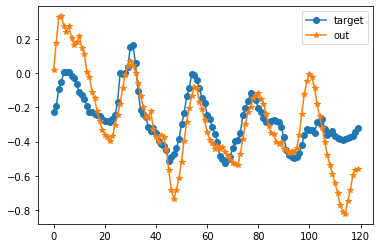

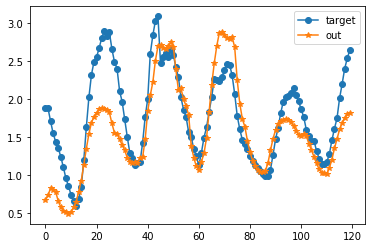

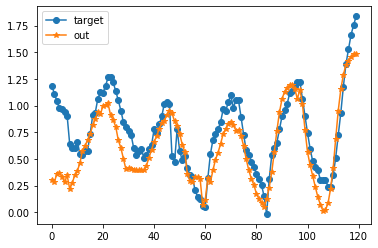

In [567]:
plot_takes(*get_n_takes(3))

0
1
2
3


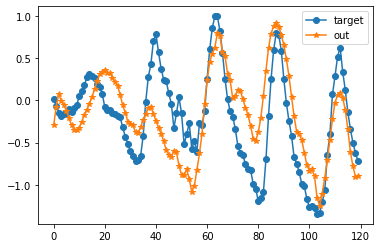

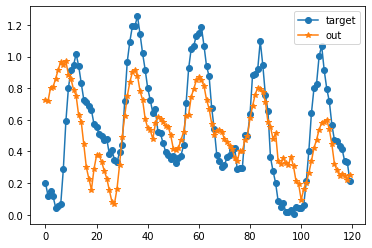

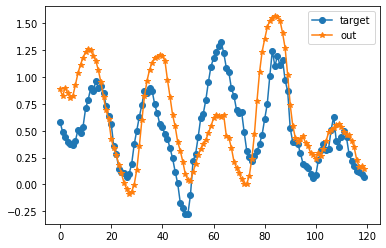

In [568]:
plot_takes(*get_n_takes(3), 1)

In [569]:
dbi = iter(db.valid_dl)
x,y = next(dbi)
rx = learn.model(x)


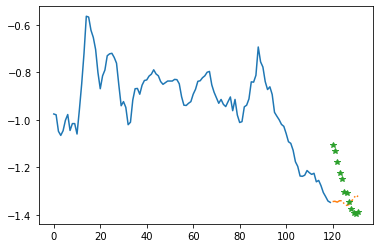

In [570]:
ch = 0
plt.plot(x[ch,:,1])
plt.plot(len(y[0])+np.arange(12),y[ch,-12:], '-.')
plt.plot(len(y[0])+np.arange(12),rx[ch,-12:], '*')

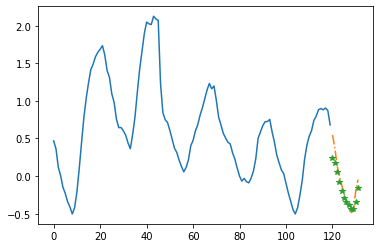

In [571]:
ch = 1
plt.plot(x[ch,:,1])
plt.plot(len(y[0])+np.arange(12),y[ch,-12:], '-.')
plt.plot(len(y[0])+np.arange(12),rx[ch,-12:], '*')

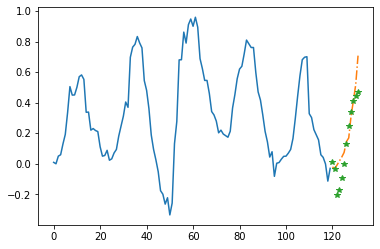

In [572]:
ch = 2
plt.plot(x[ch,:,1])
plt.plot(len(y[0])+np.arange(12),y[ch,-12:], '-.')
plt.plot(len(y[0])+np.arange(12),rx[ch,-12:], '*')

## tt